In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import jax
import znnl
from neural_tangents import stax
import copy
import optax

from flax import linen as nn
import flax
import jax.nn.initializers as inits

import matplotlib.pyplot as plt

import numpy as onp
import jax.numpy as np
# import time

2023-09-13 14:27:14.105479: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-13 14:27:16.852688: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-13 14:27:16.932821: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-13 14:27:26.407757: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
/tikhome

Using backend: cpu

Available hardware:

TFRT_CPU_0

# Including the trace regularization

In [ ]:
from flax.training.train_state import TrainState
from znnl.training_strategies import SimpleTraining
from typing import Callable, List, Optional, Tuple, Union
from znnl.accuracy_functions.accuracy_function import AccuracyFunction
from znnl.models.jax_model import JaxModel
from znnl.training_strategies.recursive_mode import RecursiveMode

In [333]:
 class RegularizedTraining(SimpleTraining):

    def __init__(
        self,
        model: Union[JaxModel, None],
        loss_fn: Callable,
        accuracy_fn: AccuracyFunction = None,
        seed: int = None,
        recursive_mode: RecursiveMode = None,
        disable_loading_bar: bool = False,
        recorders: List["JaxRecorder"] = None,
        regularization: float = 0.0,        
    ):
        """
        Construct a simple training strategy for a model.

        Parameters
        ----------
        model : Union[JaxModel, None]
                Model class for a Jax model.
                "None" is only used if the training strategy is passed as an input
                to a bigger framework. The strategy then is applied to the framework
                and the model instantiation is handled by that framework.
        loss_fn : Callable
                A function to use in the loss computation.
        accuracy_fn : AccuracyFunction (default = None)
                Funktion class for computing the accuracy of model and given data.
        seed : int (default = None)
                Random seed for the RNG. Uses a random int if not specified.
        recursive_mode : RecursiveMode
                Defining the recursive mode that can be used in training.
                If the recursive mode is used, the training will be performed until a
                condition is fulfilled.
        disable_loading_bar : bool
                Disable the output visualization of the loading bar.
        recorders : List[JaxRecorder]
                A list of recorders to monitor model training.
        """
        super().__init__(
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            seed=seed,
            recursive_mode=recursive_mode,
            disable_loading_bar=disable_loading_bar,
            recorders=recorders,
        )
        self.regularization = regularization

                
    def _train_step(self, state: TrainState, batch: dict):
        """
        Train a single step.

        Parameters
        ----------
        state : TrainState
                Current state of the neural network.
        batch : dict
                Batch of data to train on.

        Returns
        -------
        state : dict
                Updated state of the neural network.
        metrics : dict
                Metrics for the current model.
        """

        def network_grad_fn(params):
                """
                helper grad computation
                """
                traced_predictions = self.model.apply(params, batch["inputs"]).sum(axis=1)
                ntk_trace_values = np.mean(traced_predictions)
                return ntk_trace_values 

        def loss_fn(params):
                """
                helper loss computation
                """
                inner_predictions = self.model.apply(params, batch["inputs"])
                loss = self.loss_fn(inner_predictions, batch["targets"])

                # Add gradient regularization
                if self.regularization > 0.0:
                        grad = jax.grad(network_grad_fn)(params)
                        grad_square = jax.tree_map(lambda x: x ** 2, grad)
                        loss += self.regularization * jax.flatten_util.ravel_pytree(grad_square)[0].mean()

                return loss, inner_predictions

        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

        (_, predictions), grads = grad_fn(state.params)

        state = state.apply_gradients(grads=grads)  # in place state update.
        metrics = self._compute_metrics(
            predictions=predictions, targets=batch["targets"]
        )

        return state, metrics
    

# Set up Model

In [334]:
data_generator = znnl.data.MNISTGenerator(ds_size=50)

In [335]:
class Network(nn.Module):
    """
    Simple CNN module.
    """
    @nn.compact
    def __call__(self, x):        
        x = x.reshape((x.shape[0], -1))  # flatten
        
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        return x

# Execute training

In [343]:
model = znnl.models.FlaxModel(
        flax_module=Network(),
        optimizer=optax.adam(learning_rate=0.01),
        input_shape=(1, 28, 28, 1),
        seed=0, 
    )

train_recorder = znnl.training_recording.JaxRecorder(
    name="train_recorder",
    loss=True,
    ntk=True,
    entropy= True, 
    trace=True,
    loss_derivative=True,
    update_rate=1, 
    chunk_size=1000
)
train_recorder.instantiate_recorder(
    data_set=data_generator.train_ds
)


test_recorder = znnl.training_recording.JaxRecorder(
    name="test_recorder",
    loss=True,
    update_rate=1,
    chunk_size=1000
)
test_recorder.instantiate_recorder(
    data_set=data_generator.test_ds
)

In [370]:
trainer = RegularizedTraining(
    model=model, 
    loss_fn=znnl.loss_functions.CrossEntropyLoss(),
    accuracy_fn=znnl.accuracy_functions.LabelAccuracy(), 
    recorders=[train_recorder, test_recorder],  
    regularization=1e-2, 
    # regularization=0.0,
    seed=0
)

In [381]:
batched_training_metrics = trainer.train_model(
    train_ds=data_generator.train_ds, 
    test_ds=data_generator.test_ds,
    batch_size=32,
    epochs=100,
)

Epoch: 1:   0%|                                                          | 0/100 [00:00<?, ?batch/s]/tmp/ipykernel_503965/4271076503.py:88: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  grad_square = jax.tree_map(lambda x: x ** 2, grad)
Epoch: 100: 100%|███████████████████████████████| 100/100 [00:17<00:00,  5.77batch/s, accuracy=0.54]


In [382]:
train_report = train_recorder.gather_recording()
test_report = test_recorder.gather_recording()

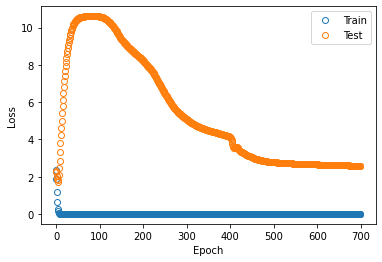

In [386]:
plt.plot(train_report.loss, 'o', mfc='None', label="Train")
plt.plot(test_report.loss, 'o', mfc='None', label="Test")

plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.yscale("log")
plt.legend()
plt.show()

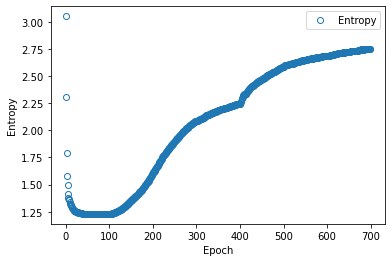

In [384]:
plt.plot(train_report.entropy, 'o', mfc='None', label="Entropy")
plt.xlabel("Epoch")
plt.ylabel("Entropy")
plt.legend()
plt.show()

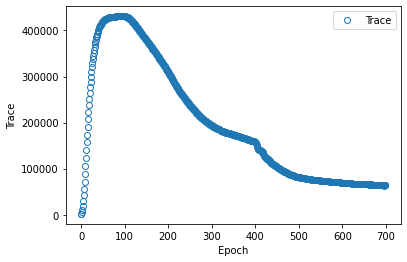

In [385]:
plt.plot(train_report.trace, 'o', mfc='None', label="Trace")
plt.xlabel("Epoch")
plt.ylabel("Trace")
plt.legend()
plt.show()